In [31]:
#install required libraries
from statistics import mean

from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek

#from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier#, AdaBoostClassifier, GradientBoostingClassifier
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
#from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, fbeta_score, precision_score, \
                            recall_score, roc_auc_score, classification_report, f1_score, roc_curve
                            
from sklearn.base import TransformerMixin

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import RFECV


import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings


warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
#Read Data
#load downloaded file
INPUT_PATH = r"C:\Users\User\Desktop\portfolio\cc_defaulter_prediction\artifacts\data_ingestion\CreditCardClients.xls"
df = pd.read_excel(INPUT_PATH, header=1)

In [3]:
#drop id colum
df.drop(columns='ID', inplace=True)
#rename columns for convenience
df.rename(columns = {'PAY_0': 'PAY_1', 'default payment next month': 'Default'}, inplace=True)

#lowering column names 
df.columns = [col.lower() for col in df.columns]

In [4]:
#split the data based on class label
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=33)
# Use the split method to get the indices for training and testing
strat_train_set = None
strat_test_set = None
for train_idx, test_idx in split.split(df, df.iloc[:,-1]):
    df_train = df.loc[train_idx]
    df_test = df.loc[test_idx]
            

In [5]:
df.columns

Index(['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_1', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'default'],
      dtype='object')

Train model with all the features<br>
    - With Dummy classifier <br>
    - With engineered features <br>
    - Recursive Feature Engineering with Cross Validation <br>
    - Model interpretability <br>

In [6]:
#helper functions
def evaluate_clf(true, predicted):
    '''
    Input: True values and Predicted values
    Returns: Accuracy, F1-Score, Precision, Recall, Roc-auc Score
    '''
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted) #Calculate Roc
    return acc, f1 , precision, recall, roc_auc

In [7]:
#print confusion matrix and classification report
def display_confusion_matrix(y_true, y_pred, labels):
    '''
    This function takes y_ture, y_predicted, class labels and returns false positives and false negatives
   
    '''
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)#, normalize='all')
    print("Confusion Matrix: \n", cm)
    print("Classification Report: \n", classification_report(y_true, y_pred, labels=labels))

In [8]:
# Create a function which can evaluate models and return a report 

def evaluate_models(X_train, y_train, x_test, y_test, models):
    '''
    This function takes in X and y and models dictionary as input
   
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
   
    
    models_list = []
    model_train_accuracy_list = []
    train_f1 = []
    test_f1 = []
    model_test_accuracy_list = []
    #train_roc = []
    #test_roc =[]
    f2_score = []
    

    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(x_test)

        # Training set performance
        model_train_accuracy, model_train_f1,model_train_precision,\
        model_train_recall,model_train_rocauc_score=evaluate_clf(y_train ,y_train_pred)


        # Test set performance
        model_test_accuracy,model_test_f1,model_test_precision,\
        model_test_recall,model_test_rocauc_score=evaluate_clf(y_test, y_test_pred)
        
        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])
        model_train_accuracy_list.append(model_train_accuracy)
        model_test_accuracy_list.append(model_test_accuracy)
        train_f1.append(model_train_f1)
        test_f1.append(model_test_f1)
        #train_roc.append(model_train_rocauc_score)
        #test_roc.append(model_test_rocauc_score)
        f2_score.append(fbeta_score(y_test, y_test_pred, beta=2))

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        #print('- Precision: {:.4f}'.format(model_train_precision))
        #print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))
        display_confusion_matrix(y_train, y_train_pred, model.classes_)


        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        print('- F1 score: {:.4f}'.format(model_test_f1))
        #print('- Precision: {:.4f}'.format(model_test_precision))
        #print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        display_confusion_matrix(y_test, y_test_pred, model.classes_)

        
        print('='*35)
        print('\n')
        
    report_data = {
        'Model Name': models_list,
        'Train Accuracy': model_train_accuracy_list,
      #  'Train_ROC_AUC_score': train_roc,
        'Test Accuracy': model_test_accuracy_list,
        'Train_F1': train_f1,

        'Test_F1': test_f1,
      #  'Test_ROC_AUC_score': test_roc
        'F2-Score':f2_score
    }
    
    report = pd.DataFrame(report_data).sort_values(by=['F2-Score', 'Test_F1'], ascending=False)        
    return report

In [9]:
#list of classification models
models = {
    "Baseline Classifier": DummyClassifier(strategy='most_frequent'),
    "Logistic Regression": LogisticRegression(class_weight='balanced'),
    "SVM": SVC(class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(class_weight='balanced')
}

In [10]:

def preprocess(numeric_features, categorical_features):#, model_name, model):
    '''
    input: list of numerical features and categorical features
    applies transformers on given data
    returns: preprocessed object
    '''
    
    # Create transformers
    categorical_transformer = OneHotEncoder()
    #feature_generator = FeatureGenerator()
    # Create transformers
    numeric_transformer = Pipeline(steps=[('scaler', RobustScaler())])

    categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

        # Create a column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Create the pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
    
    return pipeline

In [11]:
categorical_features = ['sex', 'education', 'marriage','pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
numeric_cols = ['age','limit_bal', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', \
                 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']
#engineered_cols = ['overdraft']#'avg_leverage_ratio', 'avg_bill_to_pay', 'overdraft']

In [12]:
X_train = df_train.drop('default', axis=1)
y_train = df_train['default']

x_test=df_test.drop('default', axis=1)
y_test=df_test['default']

pipeline = preprocess(numeric_cols, categorical_features)
X_train_transformed = pipeline.fit_transform(X_train)
x_test_transformed = pipeline.transform(x_test)
column_names=pipeline.named_steps['preprocessor'].get_feature_names_out()
X_train_transformed_df = pd.DataFrame(X_train_transformed.toarray(), columns = column_names)
x_test_transformed_df = pd.DataFrame(x_test_transformed.toarray(), columns = column_names)

In [13]:
pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)

array(['sex_1', 'sex_2', 'education_0', 'education_1', 'education_2',
       'education_3', 'education_4', 'education_5', 'education_6',
       'marriage_0', 'marriage_1', 'marriage_2', 'marriage_3', 'pay_1_-2',
       'pay_1_-1', 'pay_1_0', 'pay_1_1', 'pay_1_2', 'pay_1_3', 'pay_1_4',
       'pay_1_5', 'pay_1_6', 'pay_1_7', 'pay_1_8', 'pay_2_-2', 'pay_2_-1',
       'pay_2_0', 'pay_2_1', 'pay_2_2', 'pay_2_3', 'pay_2_4', 'pay_2_5',
       'pay_2_6', 'pay_2_7', 'pay_2_8', 'pay_3_-2', 'pay_3_-1', 'pay_3_0',
       'pay_3_1', 'pay_3_2', 'pay_3_3', 'pay_3_4', 'pay_3_5', 'pay_3_6',
       'pay_3_7', 'pay_3_8', 'pay_4_-2', 'pay_4_-1', 'pay_4_0', 'pay_4_1',
       'pay_4_2', 'pay_4_3', 'pay_4_4', 'pay_4_5', 'pay_4_6', 'pay_4_7',
       'pay_4_8', 'pay_5_-2', 'pay_5_-1', 'pay_5_0', 'pay_5_2', 'pay_5_3',
       'pay_5_4', 'pay_5_5', 'pay_5_6', 'pay_5_7', 'pay_5_8', 'pay_6_-2',
       'pay_6_-1', 'pay_6_0', 'pay_6_2', 'pay_6_3', 'pay_6_4', 'pay_6_5',
       'pay_6_6', 'pay_6_7', 'pay_6_8'], dtype=

In [14]:
report1 = evaluate_models(X_train=X_train_transformed_df, y_train=y_train, x_test=x_test_transformed_df, y_test=y_test, models=models)
report1    

Baseline Classifier
Model performance for Training set
- Accuracy: 0.7788
- F1 score: 0.0000
- Roc Auc Score: 0.5000
Confusion Matrix: 
 [[18691     0]
 [ 5309     0]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.78      1.00      0.88     18691
           1       0.00      0.00      0.00      5309

    accuracy                           0.78     24000
   macro avg       0.39      0.50      0.44     24000
weighted avg       0.61      0.78      0.68     24000

----------------------------------
Model performance for Test set
- Accuracy: 0.7788
- F1 score: 0.0000
- Roc Auc Score: 0.5000
Confusion Matrix: 
 [[4673    0]
 [1327    0]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.78      1.00      0.88      4673
           1       0.00      0.00      0.00      1327

    accuracy                           0.78      6000
   macro avg       0.39      0.50      0.44      6000
weighted

,Model Name,Train Accuracy,Test Accuracy,Train_F1,Test_F1,F2-Score
1,Logistic Regression,0.776833,0.773500,0.536036,0.533150,0.562972
2,SVM,0.789542,0.780833,0.535796,0.515654,0.522700
3,Decision Tree,0.999417,0.732167,0.998683,0.399701,0.401772
4,Random Forest,0.999500,0.820667,0.998871,0.463074,0.387636
0,Baseline Classifier,0.778792,0.778833,0.000000,0.000000,0.000000


### With engineered features: 

In [15]:
class FeatureGenerator(TransformerMixin):
    
    '''
    Upon calling fit_transform or transform method this column generates new dataframe columns
    '''
    def __init__(self):
      
        try:
            self.bill_amt1_ix = "bill_amt1"
            self.bill_amt2_ix = "bill_amt2"
            self.bill_amt3_ix = "bill_amt3"
            self.bill_amt4_ix = "bill_amt4"
            self.bill_amt5_ix = "bill_amt5"
            self.bill_amt6_ix = "bill_amt6"
            self.limit_bal_ix = "limit_bal"
            self.pay_amt1_ix = "pay_amt1"
            self.pay_amt2_ix = "pay_amt2"
            self.pay_amt3_ix = "pay_amt3"
            self.pay_amt4_ix = "pay_amt4"
            self.pay_amt5_ix = "pay_amt5"
            self.pay_amt6_ix = "pay_amt6"
            

        except Exception as e:
            print(e)


    def fit(self, X):
        return self

    def transform(self, X):
        '''
            X['leverage_1'] = X[self.bill_amt1_ix]/X[self.limit_bal_ix]   
            X['leverage_2'] = X[self.bill_amt2_ix]/X[self.limit_bal_ix]
            X['leverage_3'] = X[self.bill_amt3_ix]/X[self.limit_bal_ix]
            X['leverage_4'] = X[self.bill_amt4_ix]/X[self.limit_bal_ix]
            X['leverage_5'] = X[self.bill_amt5_ix]/X[self.limit_bal_ix]
            X['leverage_6'] = X[self.bill_amt6_ix]/X[self.limit_bal_ix]

            X['bill_to_pay1'] = X[self.bill_amt1_ix]/(X[self.pay_amt1_ix]+1)   
            X['bill_to_pay2'] = X[self.bill_amt2_ix]/(X[self.pay_amt2_ix]+1)
            X['bill_to_pay3'] = X[self.bill_amt3_ix]/(X[self.pay_amt3_ix]+1)
            X['bill_to_pay4'] = X[self.bill_amt4_ix]/(X[self.pay_amt4_ix]+1)
            X['bill_to_pay5'] = X[self.bill_amt5_ix]/(X[self.pay_amt5_ix]+1)
            X['bill_to_pay6'] = X[self.bill_amt6_ix]/(X[self.pay_amt6_ix]+1)
            
            X['overdraft'] = np.where(   (X[self.bill_amt1_ix]>X[self.limit_bal_ix]) |
                                        (X[self.bill_amt2_ix]>X[self.limit_bal_ix]) |
                                        (X[self.bill_amt3_ix]>X[self.limit_bal_ix]) |
                                        (X[self.bill_amt4_ix]>X[self.limit_bal_ix]) |
                                        (X[self.bill_amt5_ix]>X[self.limit_bal_ix]) |
                                        (X[self.bill_amt6_ix]>X[self.limit_bal_ix]),
                                        1, 0                                 
                                    )
        '''
        X['avg_bill_amt'] = (X[self.bill_amt1_ix]+X[self.bill_amt2_ix]+X[self.bill_amt3_ix] \
                                     +X[self.bill_amt4_ix]+X[self.bill_amt5_ix]+X[self.bill_amt6_ix])/6
        X['avg_leverage_ratio'] = (X[self.bill_amt1_ix]+X[self.bill_amt2_ix]+X[self.bill_amt3_ix] \
                                       +X[self.bill_amt4_ix]+X[self.bill_amt5_ix]+X[self.bill_amt6_ix])/(6*X[self.limit_bal_ix])
        X['avg_pay_amt'] = (X[self.pay_amt1_ix]+X[self.pay_amt2_ix]+X[self.pay_amt3_ix] \
                                      +X[self.pay_amt4_ix]+X[self.pay_amt5_ix]+X[self.pay_amt6_ix])/6
        X['avg_bill_to_pay'] = (X[self.bill_amt1_ix]+X[self.bill_amt2_ix]+X[self.bill_amt3_ix] \
                                       +X[self.bill_amt4_ix]+X[self.bill_amt5_ix]+X[self.bill_amt6_ix])/ \
                                        ((X[self.pay_amt1_ix]+X[self.pay_amt2_ix]+X[self.pay_amt3_ix] \
                                       +X[self.pay_amt4_ix]+X[self.pay_amt5_ix]+X[self.pay_amt6_ix])+1)

        return X


In [16]:

def preprocess1(numeric_features, categorical_features):#, model_name, model):
    '''
    input: list of numerical features and categorical features
    applies transformers on given data
    returns: preprocessed object
    '''
    
    # Create transformers
    categorical_transformer = OneHotEncoder()
    feature_generator = FeatureGenerator()
    
    # Create transformers
    numeric_transformer = Pipeline(steps=[('scaler', RobustScaler())])

    categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

        # Create a column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Create the pipeline
    pipeline = Pipeline(steps=[('feature generator', feature_generator),('preprocessor', preprocessor)])
    
    return pipeline

In [17]:
categorical_features = ['sex', 'education', 'marriage','pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
numeric_cols = ['age','limit_bal', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', \
                 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']
engineered_cols = ['avg_bill_amt', 'avg_leverage_ratio', 'avg_pay_amt', 'avg_bill_to_pay']
#engineered_cols = ['leverage_1', 'leverage_2', 'leverage_3', 'leverage_4', 'leverage_5', 'leverage_6', 'bill_to_pay1', \
#                   'bill_to_pay2', 'bill_to_pay3', 'bill_to_pay4', 'bill_to_pay5', 'bill_to_pay6', \
#                   'overdraft', 'avg_bill_amt', 'avg_leverage_ratio', 'avg_pay_amt', 'avg_bill_to_pay']


In [18]:
X_train = df_train.drop('default', axis=1)
y_train = df_train['default']

x_test=df_test.drop('default', axis=1)
y_test=df_test['default']
num_cols = numeric_cols+engineered_cols
pipeline = preprocess1(num_cols, categorical_features)
X_train_transformed = pipeline.fit_transform(X_train)
x_test_transformed = pipeline.transform(x_test)
column_names = pipeline[1:].named_steps['preprocessor'].get_feature_names_out()
X_train_transformed_df = pd.DataFrame(X_train_transformed.toarray(), columns = column_names)
x_test_transformed_df = pd.DataFrame(x_test_transformed.toarray(), columns = column_names)

In [19]:
#type(pipeline[:-1].named_steps['preprocessor']).get_feature_names_out(numeric_cols)
#pipeline.named_steps['preprocessor'].named_transformers_
len(pipeline[1:].named_steps['preprocessor'].get_feature_names_out())

95

In [20]:
report2 = evaluate_models(X_train=X_train_transformed_df, y_train=y_train, x_test=x_test_transformed_df, y_test=y_test, models=models)
report2  

Baseline Classifier
Model performance for Training set
- Accuracy: 0.7788
- F1 score: 0.0000
- Roc Auc Score: 0.5000
Confusion Matrix: 
 [[18691     0]
 [ 5309     0]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.78      1.00      0.88     18691
           1       0.00      0.00      0.00      5309

    accuracy                           0.78     24000
   macro avg       0.39      0.50      0.44     24000
weighted avg       0.61      0.78      0.68     24000

----------------------------------
Model performance for Test set
- Accuracy: 0.7788
- F1 score: 0.0000
- Roc Auc Score: 0.5000
Confusion Matrix: 
 [[4673    0]
 [1327    0]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.78      1.00      0.88      4673
           1       0.00      0.00      0.00      1327

    accuracy                           0.78      6000
   macro avg       0.39      0.50      0.44      6000
weighted

,Model Name,Train Accuracy,Test Accuracy,Train_F1,Test_F1,F2-Score
1,Logistic Regression,0.754750,0.761167,0.518015,0.526594,0.568636
3,Decision Tree,0.999417,0.738167,0.998683,0.406498,0.405854
4,Random Forest,0.999458,0.819000,0.998777,0.457542,0.382751
2,SVM,0.776917,0.777167,0.063003,0.051100,0.033395
0,Baseline Classifier,0.778792,0.778833,0.000000,0.000000,0.000000


Recursive Feature Elimination with Cross validation

Optimal number of features: 84


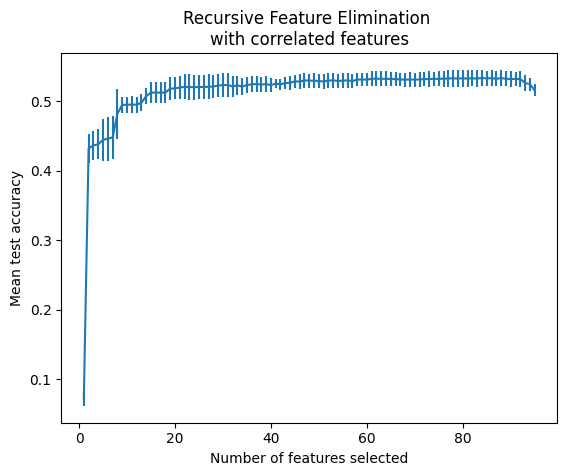

In [21]:
min_features_to_select = 1  # Minimum number of features to consider
clf = LogisticRegression(class_weight='balanced')
cv = StratifiedKFold(5)

rfecv_lr = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring='f1',
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
rfecv_lr.fit(X_train_transformed_df, y_train)

print(f"Optimal number of features: {rfecv_lr.n_features_}")


# Plot number of features VS. cross-validation scores
# ---------------------------------------------------

import matplotlib.pyplot as plt

n_scores = len(rfecv_lr.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv_lr.cv_results_["mean_test_score"],
    yerr=rfecv_lr.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [22]:
rfecv_lr.get_feature_names_out()

array(['num__age', 'num__limit_bal', 'num__bill_amt3', 'num__bill_amt4',
       'num__bill_amt5', 'num__bill_amt6', 'num__pay_amt1',
       'num__pay_amt2', 'num__avg_bill_amt', 'num__avg_leverage_ratio',
       'num__avg_pay_amt', 'cat__sex_1', 'cat__sex_2', 'cat__education_0',
       'cat__education_1', 'cat__education_2', 'cat__education_3',
       'cat__education_4', 'cat__education_5', 'cat__education_6',
       'cat__marriage_0', 'cat__marriage_1', 'cat__marriage_2',
       'cat__marriage_3', 'cat__pay_1_-2', 'cat__pay_1_-1',
       'cat__pay_1_0', 'cat__pay_1_1', 'cat__pay_1_2', 'cat__pay_1_3',
       'cat__pay_1_4', 'cat__pay_1_5', 'cat__pay_1_6', 'cat__pay_1_7',
       'cat__pay_2_-2', 'cat__pay_2_-1', 'cat__pay_2_0', 'cat__pay_2_1',
       'cat__pay_2_2', 'cat__pay_2_3', 'cat__pay_2_4', 'cat__pay_2_5',
       'cat__pay_2_6', 'cat__pay_2_7', 'cat__pay_2_8', 'cat__pay_3_-2',
       'cat__pay_3_-1', 'cat__pay_3_0', 'cat__pay_3_1', 'cat__pay_3_2',
       'cat__pay_3_3', 'cat__pay

In [24]:
X_train_fs1_df = X_train_transformed_df[rfecv_lr.get_feature_names_out()]
x_test_fs1_df = x_test_transformed_df[rfecv_lr.get_feature_names_out()]
report3 = evaluate_models(X_train_fs1_df, y_train, x_test_fs1_df, y_test, models)
report3

Baseline Classifier
Model performance for Training set
- Accuracy: 0.7788
- F1 score: 0.0000
- Roc Auc Score: 0.5000
Confusion Matrix: 
 [[18691     0]
 [ 5309     0]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.78      1.00      0.88     18691
           1       0.00      0.00      0.00      5309

    accuracy                           0.78     24000
   macro avg       0.39      0.50      0.44     24000
weighted avg       0.61      0.78      0.68     24000

----------------------------------
Model performance for Test set
- Accuracy: 0.7788
- F1 score: 0.0000
- Roc Auc Score: 0.5000
Confusion Matrix: 
 [[4673    0]
 [1327    0]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.78      1.00      0.88      4673
           1       0.00      0.00      0.00      1327

    accuracy                           0.78      6000
   macro avg       0.39      0.50      0.44      6000
weighted

,Model Name,Train Accuracy,Test Accuracy,Train_F1,Test_F1,F2-Score
1,Logistic Regression,0.777667,0.775333,0.535354,0.533564,0.561054
2,SVM,0.781375,0.777667,0.538563,0.531272,0.553684
3,Decision Tree,0.999417,0.737000,0.998683,0.418142,0.423577
4,Random Forest,0.999458,0.821833,0.998776,0.472620,0.398635
0,Baseline Classifier,0.778792,0.778833,0.000000,0.000000,0.000000


Optimal number of features: 22


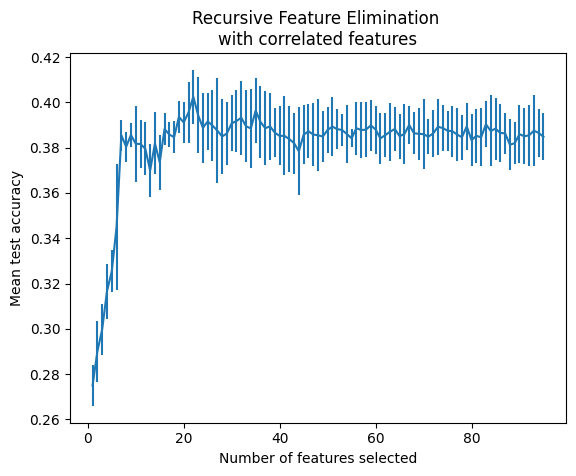

In [25]:
min_features_to_select = 1  # Minimum number of features to consider
clf = DecisionTreeClassifier(class_weight='balanced')
cv = StratifiedKFold(5)

rfecv_dt = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring='f1',
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
rfecv_dt.fit(X_train_transformed_df, y_train)

print(f"Optimal number of features: {rfecv_dt.n_features_}")


# Plot number of features VS. cross-validation scores
# ---------------------------------------------------

import matplotlib.pyplot as plt

n_scores = len(rfecv_dt.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv_dt.cv_results_["mean_test_score"],
    yerr=rfecv_dt.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [26]:
rfecv_dt.get_feature_names_out()

array(['num__age', 'num__limit_bal', 'num__bill_amt1', 'num__bill_amt2',
       'num__bill_amt3', 'num__bill_amt4', 'num__bill_amt5',
       'num__bill_amt6', 'num__pay_amt1', 'num__pay_amt2',
       'num__pay_amt3', 'num__pay_amt4', 'num__pay_amt5', 'num__pay_amt6',
       'num__avg_bill_amt', 'num__avg_leverage_ratio', 'num__avg_pay_amt',
       'num__avg_bill_to_pay', 'cat__sex_1', 'cat__pay_1_2',
       'cat__pay_2_2', 'cat__pay_4_2'], dtype=object)

In [27]:
X_train_fs2_df = X_train_transformed_df[rfecv_dt.get_feature_names_out()]
x_test_fs2_df = x_test_transformed_df[rfecv_dt.get_feature_names_out()]

In [28]:
report4 = evaluate_models(X_train_fs2_df, y_train, x_test_fs2_df, y_test, models)
report4

Baseline Classifier
Model performance for Training set
- Accuracy: 0.7788
- F1 score: 0.0000
- Roc Auc Score: 0.5000
Confusion Matrix: 
 [[18691     0]
 [ 5309     0]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.78      1.00      0.88     18691
           1       0.00      0.00      0.00      5309

    accuracy                           0.78     24000
   macro avg       0.39      0.50      0.44     24000
weighted avg       0.61      0.78      0.68     24000

----------------------------------
Model performance for Test set
- Accuracy: 0.7788
- F1 score: 0.0000
- Roc Auc Score: 0.5000
Confusion Matrix: 
 [[4673    0]
 [1327    0]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.78      1.00      0.88      4673
           1       0.00      0.00      0.00      1327

    accuracy                           0.78      6000
   macro avg       0.39      0.50      0.44      6000
weighted

,Model Name,Train Accuracy,Test Accuracy,Train_F1,Test_F1,F2-Score
1,Logistic Regression,0.743042,0.731500,0.498659,0.486124,0.535413
3,Decision Tree,0.996917,0.729000,0.993078,0.394188,0.396849
4,Random Forest,0.997500,0.815167,0.994367,0.442433,0.368509
2,SVM,0.777000,0.777167,0.063025,0.051100,0.033395
0,Baseline Classifier,0.778792,0.778833,0.000000,0.000000,0.000000


In [32]:

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='auto',n_jobs=-1)
# Fit the model to generate the data.
X_train_transformed_sampled, y_train_sampled = smt.fit_resample(X_train_transformed_df, y_train)
report5 = evaluate_models(X_train_transformed_sampled, y_train_sampled, x_test_transformed_df, y_test, models)
report5

Baseline Classifier
Model performance for Training set
- Accuracy: 0.5000
- F1 score: 0.0000
- Roc Auc Score: 0.5000
Confusion Matrix: 
 [[18385     0]
 [18385     0]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.50      1.00      0.67     18385
           1       0.00      0.00      0.00     18385

    accuracy                           0.50     36770
   macro avg       0.25      0.50      0.33     36770
weighted avg       0.25      0.50      0.33     36770

----------------------------------
Model performance for Test set
- Accuracy: 0.7788
- F1 score: 0.0000
- Roc Auc Score: 0.5000
Confusion Matrix: 
 [[4673    0]
 [1327    0]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.78      1.00      0.88      4673
           1       0.00      0.00      0.00      1327

    accuracy                           0.78      6000
   macro avg       0.39      0.50      0.44      6000
weighted

,Model Name,Train Accuracy,Test Accuracy,Train_F1,Test_F1,F2-Score
2,SVM,0.609301,0.500333,0.669291,0.409610,0.574015
1,Logistic Regression,0.697824,0.766333,0.657544,0.527310,0.562833
4,Random Forest,0.999674,0.805500,0.999674,0.523089,0.497822
3,Decision Tree,0.999674,0.704500,0.999674,0.414658,0.447932
0,Baseline Classifier,0.500000,0.778833,0.000000,0.000000,0.000000


In [29]:
X_train_transformed_df.columns

Index(['num__age', 'num__limit_bal', 'num__bill_amt1', 'num__bill_amt2',
       'num__bill_amt3', 'num__bill_amt4', 'num__bill_amt5', 'num__bill_amt6',
       'num__pay_amt1', 'num__pay_amt2', 'num__pay_amt3', 'num__pay_amt4',
       'num__pay_amt5', 'num__pay_amt6', 'num__avg_bill_amt',
       'num__avg_leverage_ratio', 'num__avg_pay_amt', 'num__avg_bill_to_pay',
       'cat__sex_1', 'cat__sex_2', 'cat__education_0', 'cat__education_1',
       'cat__education_2', 'cat__education_3', 'cat__education_4',
       'cat__education_5', 'cat__education_6', 'cat__marriage_0',
       'cat__marriage_1', 'cat__marriage_2', 'cat__marriage_3',
       'cat__pay_1_-2', 'cat__pay_1_-1', 'cat__pay_1_0', 'cat__pay_1_1',
       'cat__pay_1_2', 'cat__pay_1_3', 'cat__pay_1_4', 'cat__pay_1_5',
       'cat__pay_1_6', 'cat__pay_1_7', 'cat__pay_1_8', 'cat__pay_2_-2',
       'cat__pay_2_-1', 'cat__pay_2_0', 'cat__pay_2_1', 'cat__pay_2_2',
       'cat__pay_2_3', 'cat__pay_2_4', 'cat__pay_2_5', 'cat__pay_2_6',
  

In [ ]:
def plot_roc_auc_curve(y_true, y_pred, model, x_test, name):
    #plot Roc-auc curve
    model_roc_auc = roc_auc_score(y_true, y_pred)
    fpr, tpr, threshold = roc_curve(y_true, model.predict_proba(x_test)[:,1])
    plt.figure(figsize=(10, 5))
    #following code adapted from roc_auc_curve scikit-learn documentation
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='{0} ROC curve (area = {1:.2f})' .format(name, model_roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    

In [ ]:

 #   "Gradient Boosting": GradientBoostingClassifier(),
 #   "XGBClassifier": XGBClassifier(), 
#    "AdaBoost Classifier": AdaBoostClassifier(),
#    "K-Neighbors Classifier": KNeighborsClassifier(),
#    "Naive Bayes": GaussianNB()
}

In [ ]:
for model.values in models:
    print_result(, )

In [ ]:
#df_train.drop(columns=['sex', 'age', 'marriage','education'], inplace=True )
#df_test.drop(columns=['sex', 'age', 'marriage', 'education'], inplace=True)

X_train = df_train.drop('default', axis=1)
y_train = df_train['default']

x_test=df_test.drop('default', axis=1)
y_test=df_test['default']
num_cols = numeric_cols + engineered_cols
pipeline = preprocess(num_cols, categorical_features)
X_train_transformed = pipeline.fit_transform(X_train)
x_test_transformed = pipeline.transform(x_test)

report_fs = evaluate_models(X_train_transformed, y_train, x_test_transformed, y_test, models)
report_fs

In [ ]:
lr = LogisticRegression(class_weight='balanced',)
lr.fit(X_train_transformed, y_train)
y_pred = lr.predict(x_test_transformed)

In [ ]:
svm = SVC(class_weight='balanced', probability=True)
svm.fit(X_train_transformed, y_train)
y_pred_svm = svm.predict(x_test_transformed)

In [ ]:
model_roc_auc_lr = roc_auc_score(y_test, y_pred)
fpr_lr, tpr_lr, threshold_lr = roc_curve(y_test, lr.predict_proba(x_test_transformed)[:,1])
model_roc_auc_svm = roc_auc_score(y_test, y_pred_svm)
fpr_svm, tpr_svm, threshold_svm = roc_curve(y_test, svm.predict_proba(x_test_transformed)[:,1])
plt.figure(figsize=(10, 5))
#following code adapted from roc_auc_curve scikit-learn documentation
lw = 2
plt.plot(fpr_lr, tpr_lr, color='darkorange',
           lw=lw, label='{0} ROC curve (area = {1:.2f})' .format("Logistic Regression", model_roc_auc_lr))
plt.plot(fpr_svm, tpr_svm, color='lightblue',
           lw=lw, label='{0} ROC curve (area = {1:.2f})' .format("SVM", model_roc_auc_svm))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#plot_roc_auc_curve(y_test, y_pred, lr, x_test_transformed, name="Logistic Regression")

In [ ]:
#logistic regression with hyperparameter tuning
lr = LogisticRegression()
params = {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'max_iter':[100, 110, 120, 130, 140],
          'class_weight': ['balanced']}
skf= StratifiedKFold(n_splits=10)
lr_hyper = GridSearchCV(lr, param_grid=params, n_jobs=-1, cv=skf)
lr_hyper.fit(X_train_transformed, y_train)
y_pred = lr_hyper.predict(x_test_transformed)

In [ ]:
display_confusion_matrix(y_test, y_pred, lr_hyper.classes_)

In [ ]:
print(fbeta_score(y_test, y_pred, beta=2))

In [ ]:
lr_hyper.best_params_

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.compose import make_column_selector as selector

# Sample data - replace this with your actual data
data = {
    'Feature1': [1, 2, 3, None, 5],
    'Feature2': ['A', 'B', 'A', 'B', 'A'],
    'Label': [0, 1, 0, 1, 0]
}

df = pd.DataFrame(data)

# Identify numeric and categorical features
numeric_features = selector(dtype_exclude="object")
categorical_features = selector(dtype_include="object")

# Create transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the pipeline
my_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

# Split the data into features and labels
X = df.drop('Label', axis=1)
y = df['Label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline on the training data
my_pipeline.fit(X_train, y_train)

# Extract feature names using pipeline[:-1].get_feature_names_out()
feature_names = my_pipeline[:-1].named_steps['preprocessor'].get_feature_names_out()

# Make predictions on the testing data
predictions = my_pipeline.predict(X_test)

# Convert the predictions and feature names to a DataFrame
output_df = pd.DataFrame({'Prediction': predictions}, columns=feature_names)

# Display the DataFrame
print(output_df)


In [ ]:
my_pipeline[:-1].named_steps['preprocessor'].get_feature_names_out()

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector
import pandas as pd

# Sample data
data = {
    'Feature1': [1, 2, 3, None, 5],
    'Feature2': ['A', 'B', 'A', 'B', 'A'],
    'Label': [0, 1, 0, 1, 0]
}

df = pd.DataFrame(data)
df.dtypes

In [ ]:

# Identify numeric and categorical features
numeric_features_list = ['Feature1']
categorical_features_list =['Feature2']



# Create transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_list),
        ('cat', categorical_transformer, categorical_features_list)
    ])

# Create the pipeline
my_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
])

# Fit and transform the pipeline on the data
X_transformed = my_pipeline.fit_transform(df.drop('Label', axis=1))

# Get feature names for the transformed categorical features
categorical_feature_names = my_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features_list)

# Display the feature names
print(categorical_feature_names)


In [ ]:
type(my_pipeline.named_steps['preprocessor'])#.named_transformers_